## Comparison of Solution Landscapes
### BC vs dcSBM vs Spectral Methods

Load the package

In [1]:
from bayesian_cut.data.load import load_data
from bayesian_cut.cuts.bayesian_models import Model
from bayesian_cut.cuts.spectral_models import NormCutSM, RatioCut, NewmanModularityCut
import numpy as np

Load an example network

In [2]:
network_name = 'karate'
X, Y = load_data(network=network_name, labels=True, remove_disconnected=True)

/home/lauve/miniconda3/envs/bayesian_cut/lib/python3.6/site-packages/scipy/sparse/compressed.py:708: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self[i, j] = values


Set the model parameters

In [3]:
n_samples_per_chain = 75
n_chains = 15
C = 2

model_params = {
    'alpha_in': 1e-2,
    'beta_in': 1e-2,
    'alpha_out': 1e-2,
    'beta_out': 1e-2,
    'b': 1,
    'gamma': 3
}

Define the models

In [4]:
BC = Model('ShiftedApproximateBayesianCommunityDetection',
           X,
           model_params,
           Y=Y,
           C=C,
           block_sampling=False,
           marginalize_phi=True
          )
dcSBM = Model('BayesianStochasticBlockmodelSharedEtaOut',
           X,
           model_params,
           Y=Y,
           C=C,
           block_sampling=False,
           marginalize_phi=True
          )

Now let us add the number of chains for each model

In [5]:
BC.add_chains(number_of_chains=n_chains)
dcSBM.add_chains(number_of_chains=n_chains)

/home/lauve/Desktop/bayesian_cut/bayesian_cut/cuts/bayesian_models.py:145: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._X_blocks[:, self._sample_indices] = 0


Now we can run the chains for each model

In [6]:
BC.run_chains(n_samples=n_samples_per_chain,
        n_prior_updates=20,
        verbose=2,
        save_all_samples=False,
        parallel=True
    )
best_BC_solution = BC.get_best_chain().max_log_lik_z_

In [7]:
dcSBM.run_chains(n_samples=n_samples_per_chain,
        n_prior_updates=20,
        verbose=2,
        save_all_samples=False,
        parallel=True
    )
best_dcSBM_solution = dcSBM.get_best_chain().max_log_lik_z_

Remaining we have to explore the solution space of the spectral methods.

In [8]:
rc = RatioCut(X)
rc.run()
best_ratiocut = rc.z_

nc = NormCutSM(X)
nc.run()
best_normcut = rc.z_

mod = NewmanModularityCut(X)
mod.run()
best_modcut = mod.z_

After finishing the sampler for both models and running the spectral methods, we can now plot the results

In [9]:
from bayesian_cut.utils import utils

Calling the function cluster_plot and giving the model with the sampled chains will automatically create the adjacency matrix by using the best sample obtained during sampling. The ground truth group assignment is color coded as stripes on the side of the adjacency matrix.

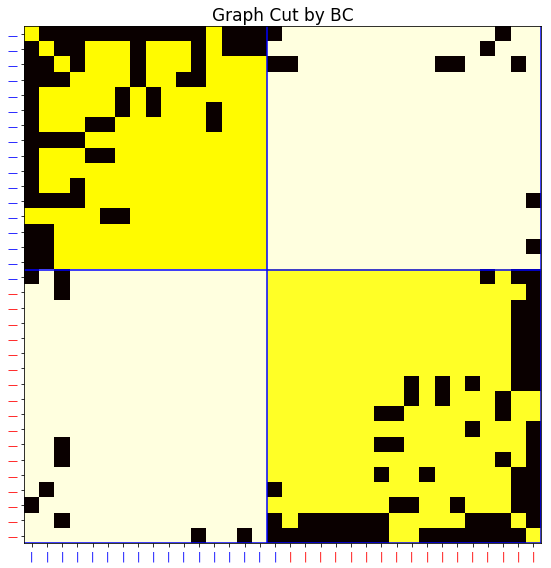

In [10]:
utils.cluster_plot(BC, ground_truth=Y, title='Graph Cut by BC')

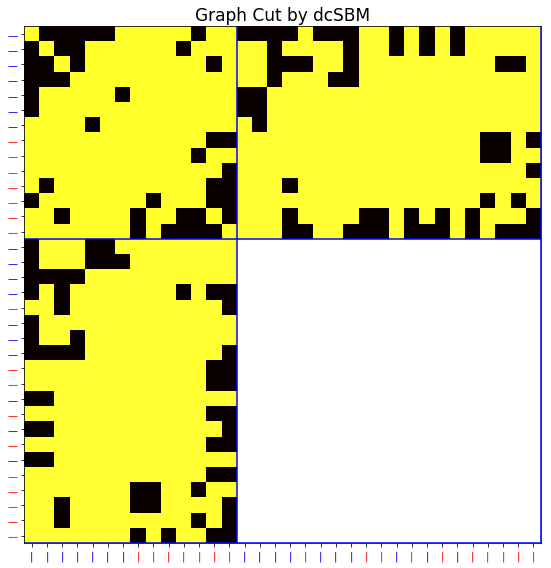

In [11]:
utils.cluster_plot(dcSBM, ground_truth=Y, title='Graph Cut by dcSBM')

Note: For spectral models the automatic z_vector detection of the cluster_plot function for the given model does not work and we have to give the Adjacency Matrix and the z_vector of the cut to the function explicitly.

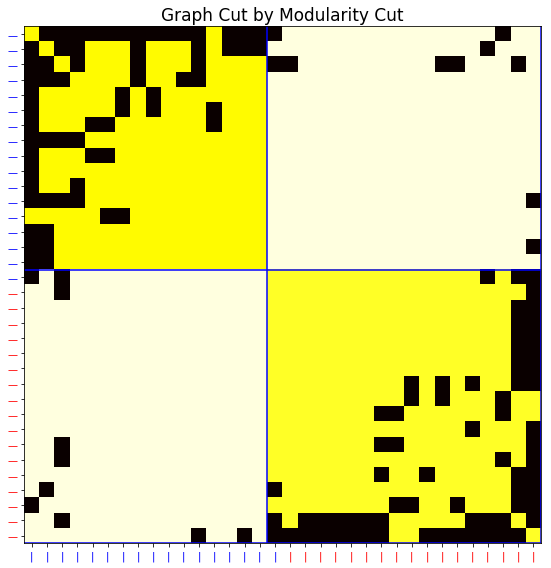

In [12]:
utils.cluster_plot(X, z_vector=best_modcut, ground_truth=Y, title='Graph Cut by Modularity Cut')

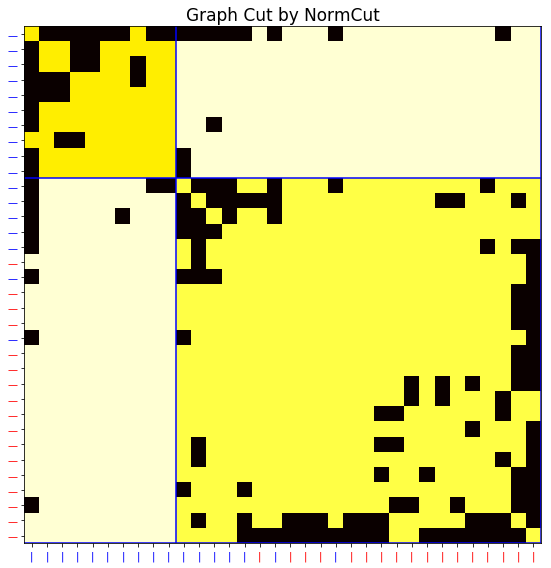

In [13]:
utils.cluster_plot(X, z_vector=best_normcut, ground_truth=Y, title='Graph Cut by NormCut')

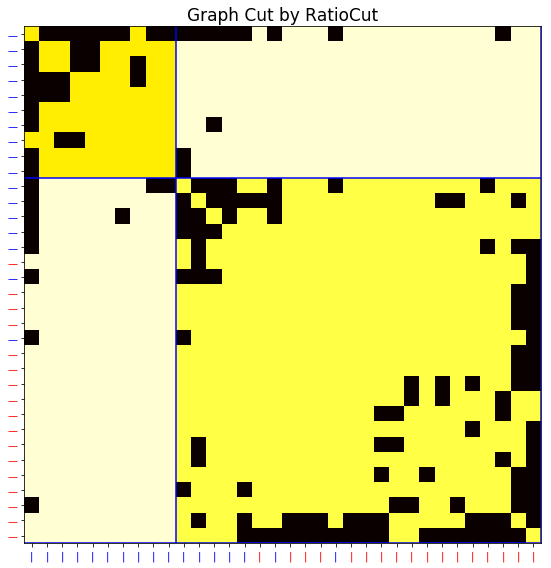

In [14]:
utils.cluster_plot(X, z_vector=best_ratiocut, ground_truth=Y, title='Graph Cut by RatioCut')

Looking at the optimal cut of each respective model, we clearly see that there is varying degree of mutual agreement, where the BayesianCut and the Modularity Cut seem to have the highest congruence.
To get a more profound understanding of the properties of each method, we will take a close look at the underlying likelihood or cost function.

As the spectral methods usually only provide one solution (due to k-means being used for RatioCut and NormCut, the solution obtained might vary), we try to explore more of the solution space close to the original solution by introducing noise to the adjaceny matrix. In this specific case we alter 3% of the number of original links of the entire network, i.e. the Karate network having 78 links we alter 23 links out of all possible links by either removing existing links or adding new ones.

In [15]:
rc_vectors = []
for i in range(200):
    rc.run(add_noiselinks=0.03)
    rc_vectors.append(rc.z_)

rc_vectors = np.vstack(rc_vectors)

In [16]:
nc_vectors=[]
for i in range(200):
    nc.run(add_noiselinks=0.03)
    nc_vectors.append(nc.z_)

nc_vectors = np.vstack(nc_vectors)

In [17]:
mod_vectors=[]
for i in range(200):
    mod.run(add_noiselinks=0.03)
    mod_vectors.append(mod.z_)

mod_vectors = np.vstack(mod_vectors)

Following, we aggregate all samples to create a combined posterior landscape

In [18]:
# Add probabilistic methods
z_matrix_bc, log_prob, _, _ = BC.aggregate_chain_samples()
z_matrix_dcsbm, log_prob, _, _ = dcSBM.aggregate_chain_samples()
combined_z_matrix = np.vstack((z_matrix_bc, z_matrix_dcsbm))

# Keep only the unique vectors
unique_z_matrix= np.unique(combined_z_matrix, axis=0)

# Add explored space spectral methods
combined_z_matrix = np.vstack((unique_z_matrix, rc_vectors))
combined_z_matrix = np.vstack((combined_z_matrix, nc_vectors))
combined_z_matrix = np.vstack((combined_z_matrix, mod_vectors))
# Add the original soultion of the spectral methods 
combined_z_matrix = np.vstack((combined_z_matrix, best_modcut))
combined_z_matrix = np.vstack((combined_z_matrix, best_normcut))
combined_z_matrix = np.vstack((combined_z_matrix, best_ratiocut))

# Keep only the unique vectors
combined_z_matrix = np.unique(combined_z_matrix, axis=0)

# Add new pseudo-random examples by mixing two randomly chosen vectors and taking randomly 50% of each vector
new_z_matrix = utils.generate_new_samples_only(int(0.8 * combined_z_matrix.shape[0]), combined_z_matrix)

# Combine the new samples with the original samples and keep only the unique ones
combined_z_matrix = np.vstack((new_z_matrix, combined_z_matrix))
combined_unique_z_matrix = np.unique(combined_z_matrix, axis=0)

Now we calculate the similarity matrix

In [19]:
sim_matrix = utils.calc_sim_matrix(combined_unique_z_matrix)

Having aggregated all samples, the log-likelihoods have to be evaluated for all samples on the Bayesian Models

In [20]:
unique_log_probs = {}

unique_log_probs['BC'] = utils.recalculate_prob_for_z(BC, combined_unique_z_matrix)
unique_log_probs['dcSBM'] = utils.recalculate_prob_for_z(dcSBM, combined_unique_z_matrix)

The same has to be done for the spectral methods. Here we have to evaluate the objective function

In [21]:
obective_func_eval = {}

obective_func_eval['RatioCut'] = utils.calc_ratiocut_scores(combined_unique_z_matrix, X)
obective_func_eval['NormCut'] = utils.calc_normcut_scores(combined_unique_z_matrix, X)
obective_func_eval['ModCut'] = utils.calc_modularity_scores(combined_unique_z_matrix, X)

In [22]:
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)

Now that we have calculated the log-likelihood/utility landscape for both models using all samples, we can plot the landscape to analyze the solution space of each model.

In [23]:
z_solutions = [best_BC_solution, best_dcSBM_solution, best_modcut, best_normcut, best_ratiocut]

In [ ]:
utils.landscape_plotting_notebook(sim_matrix, unique_log_probs['BC'], z_solutions=z_solutions,
                                  z_matrix=combined_unique_z_matrix, z_title='log-likelihood',
                                  title='Solution landscape BC')

The output of the plot is not contained in this notebook, because it will add approximately 40Mb to the size of the notebook.
Running this code will give an interactive plotly output, which looks like
![](https://github.com/DTUComputeCognitiveSystems/bayesian_cut/raw/master/examples/figures/BC_vs_dcSBM_and_Spectral.png "BC_landscape")

![](figures/BC_vs_dcSBM_and_Spectral.png "BC_landscape")

In [ ]:
utils.landscape_plotting_notebook(sim_matrix, unique_log_probs['dcSBM'], z_solutions=z_solutions,
                                  z_matrix=combined_unique_z_matrix, z_title='log-likelihood',
                                  title='Solution landscape dcSBM')

The output of the plot is not contained in this notebook, because it will add approximately 40Mb to the size of the notebook.
Running this code will give an interactive plotly output, which looks like
![](https://github.com/DTUComputeCognitiveSystems/bayesian_cut/raw/master/examples/figures/dcSBM_vs_BC_and_Spectral.png 'dcSBM_landscape')

![](figures/dcSBM_vs_BC_and_Spectral.png 'dcSBM_landscape')

Looking at those two plots, we can clearly see the impact the community constraint $b$ has on the solution landscape by removing the modes not exhibiting community structures, which leads to a more reasonable cut.

In [ ]:
utils.landscape_plotting_notebook(sim_matrix, obective_func_eval['ModCut'], z_solutions=z_solutions,
                                  z_matrix=combined_unique_z_matrix, z_title='Modularity',
                                  title='Solution landscape Modularity')

The output of the plot is not contained in this notebook, because it will add approximately 40Mb to the size of the notebook.
Running this code will give an interactive plotly output, which looks like
![](https://github.com/DTUComputeCognitiveSystems/bayesian_cut/raw/master/examples/figures/ModCut_vs_Bayesian_and_Spectral.png 'ModCut_landscape')

![](figures/ModCut_vs_Bayesian_and_Spectral.png 'ModCut_landscape')

In [ ]:
utils.landscape_plotting_notebook(sim_matrix, -obective_func_eval['NormCut'], z_solutions=z_solutions,
                                  z_matrix=combined_unique_z_matrix, z_title='Cost of Cut',
                                  title='Solution landscape NormCut')

Note: The solution landscape of the costfunction is inverted for NormCut to maintain the logic of optimum solutions having the highest value.

The output of the plot is not contained in this notebook, because it will add approximately 40Mb to the size of the notebook.
Running this code will give an interactive plotly output, which looks like
![](https://github.com/DTUComputeCognitiveSystems/bayesian_cut/raw/master/examples/figures/NormCut_vs_Bayes_and_Spectral.png 'NormCut_landscape')

![](figures/NormCut_vs_Bayes_and_Spectral.png 'NormCut_landscape')

In [ ]:
utils.landscape_plotting_notebook(sim_matrix, -obective_func_eval['RatioCut'], z_solutions=z_solutions,
                                  z_matrix=combined_unique_z_matrix, z_title='Cost of Cut',
                                  title='Solution landscape RatioCut')

Note: The solution landscape of the costfunction is inverted for RatioCut to maintain the logic of optimum solutions having the highest value.

The output of the plot is not contained in this notebook, because it will add approximately 40Mb to the size of the notebook.
Running this code will give an interactive plotly output, which looks like
![](https://github.com/DTUComputeCognitiveSystems/bayesian_cut/raw/master/examples/figures/RatioCut_vs_Bayes_and_Spectral.png 'RatioCut_landscape')

![](figures/RatioCut_vs_Bayes_and_Spectral.png 'RatioCut_landscape')

Concluding, the similarity between the spectral methods and the Bayesian Cut is clearly shown while the strongest congruence can be found between the solution landscape of the modularity cut and the bayesian Cut.
Interestingly, these two models distinguish themselves from the RatioCut and NormCut by not supporting the extremely isolated maxima those solutions obtain and thereby show their strong support for balanced communities.